In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
seed_value = 42

# PyTorch random seed
torch.manual_seed(seed_value)

# CPU random seed
random.seed(seed_value)

# NumPy random seed
np.random.seed(seed_value)

# Set device to deterministic if using GPU
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
torch.manual_seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define the dataset
dataset = datasets.ImageFolder('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', transform=transform)

# Define the sizes for train and test
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

# Split the dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


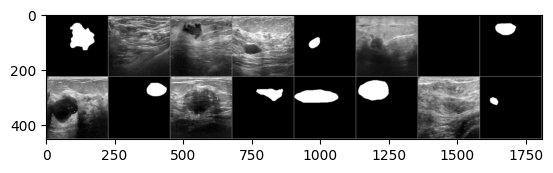

malignant normal malignant benign benign malignant normal benign benign benign malignant malignant benign benign normal benign


In [5]:
# Define the classes (assuming you have these defined)
classes = ['benign', 'malignant', 'normal']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming 'train_loader' is already defined
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [6]:
# Choose a pre-trained model or define your own
model = models.resnet50(pretrained=True)  # Example: ResNet-50

# Freeze pre-trained layers if needed
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer for your classification task
num_classes = 3  # Number of classes (benign, malignant, normal)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_losses = []
torch.manual_seed(42)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader)}")


Epoch 1 - Loss: 0.7740197411820858
Epoch 2 - Loss: 0.49028423315362085
Epoch 3 - Loss: 0.44980296266229847
Epoch 4 - Loss: 0.40255793693322167
Epoch 5 - Loss: 0.4503937023161333
Epoch 6 - Loss: 0.4162308436028565
Epoch 7 - Loss: 0.475218655565117
Epoch 8 - Loss: 0.391263242763809
Epoch 9 - Loss: 0.42246951143952866
Epoch 10 - Loss: 0.3272982408540158


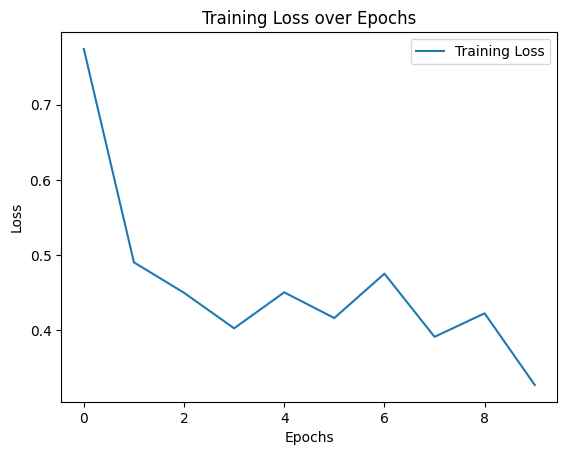

In [8]:
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")


Accuracy: 87.9746835443038%


In [10]:
# Specify the file path to save the model
model_path = 'breast_cancer_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

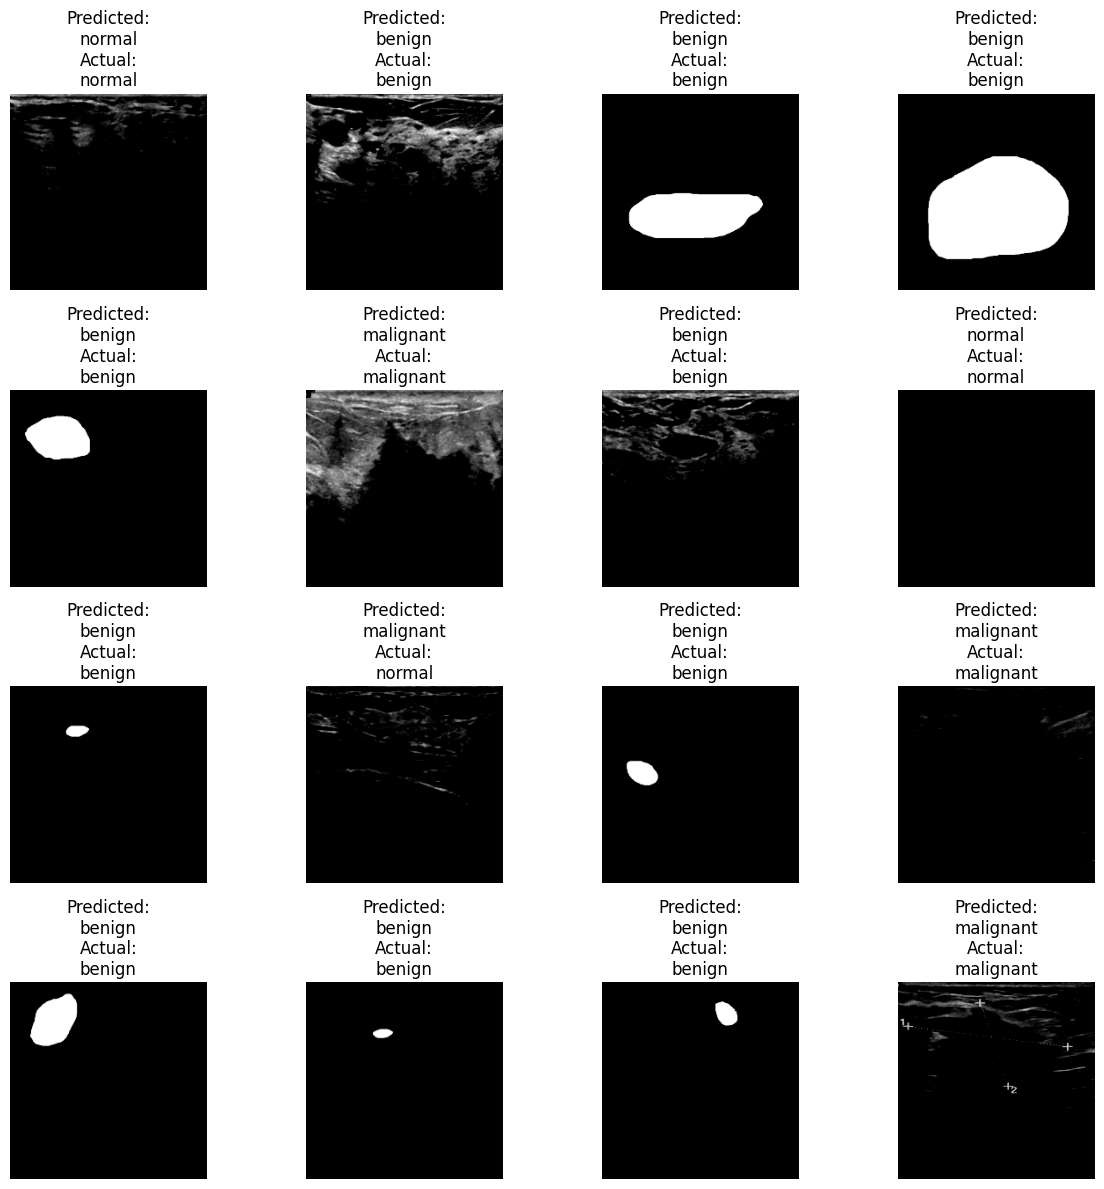

In [11]:
class_labels = {0: 'benign', 1: 'malignant', 2: 'normal'}

# Rest of your code
model.eval()

# Get a batch of test data
images, labels = next(iter(test_loader))

# Move data to the appropriate device
images = images.to(device)
labels = labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Visualize a few images and their predicted labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
    ax.imshow(image)
    predicted_label = class_labels[predicted[i].item()]
    actual_label = class_labels[labels[i].item()]

    # Provide each label in a separate line
    ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

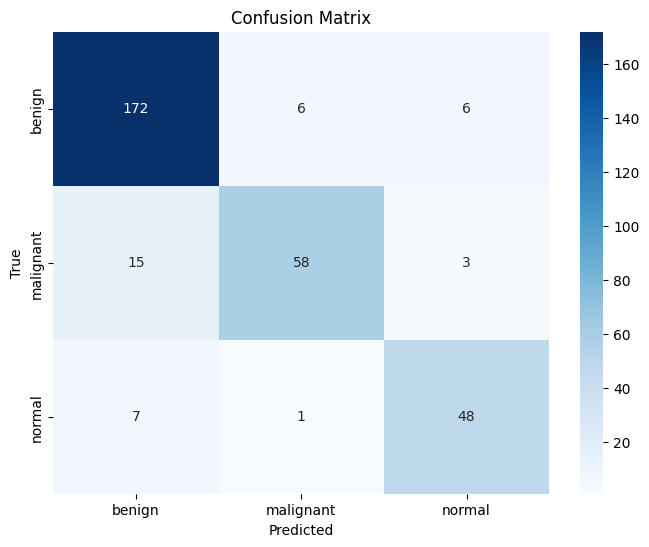

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluation loop
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()